# Scarches integration

strategy 1:

rebuild the reference using SCANVI, query on Xenium

strategy 2:

Use the processed, Seurat integration data, query on Xenium

In [1]:
import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [21]:
import scanpy as sc
import torch
import scarches as sca
from scarches.dataset.trvae.data_handling import remove_sparsity
import matplotlib.pyplot as plt
import numpy as np
import gdown
import seaborn as sns

In [3]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

In [25]:
xen_dat = sc.read_h5ad("/mnt/isilon/cscb/Projects/10x_xenium/pillaiv/data/clustering_with_neighbourhoods_anndata_mcd_spatial.h5ad")
seu_dat = sc.read_h5ad("data/seu_R-CD_RNA.h5ad")


In [5]:
print(len(set(xen_dat.var_names).intersection(seu_dat.var_names))/len(xen_dat.var_names))
set(xen_dat.var_names).difference(seu_dat.var_names)

0.8448637316561844

In [26]:
gene_overlap = list(set(xen_dat.var_names).intersection(seu_dat.var_names))
source_adata = seu_dat.raw.to_adata().copy()
source_adata.var_names = seu_dat.var_names
source_adata = source_adata[:,gene_overlap]
target_adata = xen_dat.copy()
target_adata = target_adata[:,gene_overlap]


In [27]:
target_adata = remove_sparsity(target_adata)
source_adata = remove_sparsity(source_adata)

In [42]:
target_adata.write_h5ad("xenium_dat_scarches.h5ad")

# SCANVI model

In [28]:
sca.models.SCVI.setup_anndata(source_adata, batch_key='edit.ident', labels_key='pred_anno_3')

In [29]:
vae = sca.models.SCVI(
    source_adata,
    n_layers=2,
    encode_covariates=True,
    deeply_inject_covariates=False,
    use_layer_norm="both",
    use_batch_norm="none",
)

In [30]:
vae.train()


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: SLURM auto-requeueing enabled. Setting signal handlers.
INFO:lightning.pytorch.trainer.connectors.signal_connector:SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 160/160: 100%|██████████| 160/160 [11:15<00:00,  4.19s/it, v_num=1, train_loss_step=83.2, train_loss_epoch=87]  

INFO: `Trainer.fit` stopped: `max_epochs=160` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=160` reached.


Epoch 160/160: 100%|██████████| 160/160 [11:15<00:00,  4.22s/it, v_num=1, train_loss_step=83.2, train_loss_epoch=87]


In [31]:
scanvae = sca.models.SCANVI.from_scvi_model(vae, unlabeled_category = "Unknown")

In [32]:
scanvae.train(max_epochs=20)

INFO     Training for 20 epochs.                                                                                   


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: SLURM auto-requeueing enabled. Setting signal handlers.
INFO:lightning.pytorch.trainer.connectors.signal_connector:SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 20/20: 100%|██████████| 20/20 [03:08<00:00,  9.45s/it, v_num=1, train_loss_step=96.7, train_loss_epoch=95.6]

INFO: `Trainer.fit` stopped: `max_epochs=20` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [03:08<00:00,  9.41s/it, v_num=1, train_loss_step=96.7, train_loss_epoch=95.6]


## How does it look?

In [33]:
reference_latent = sc.AnnData(scanvae.get_latent_representation())
reference_latent.obs["cell_type"] = source_adata.obs['pred_anno_3'].tolist()
reference_latent.obs["batch"] = source_adata.obs['edit.ident'].tolist()

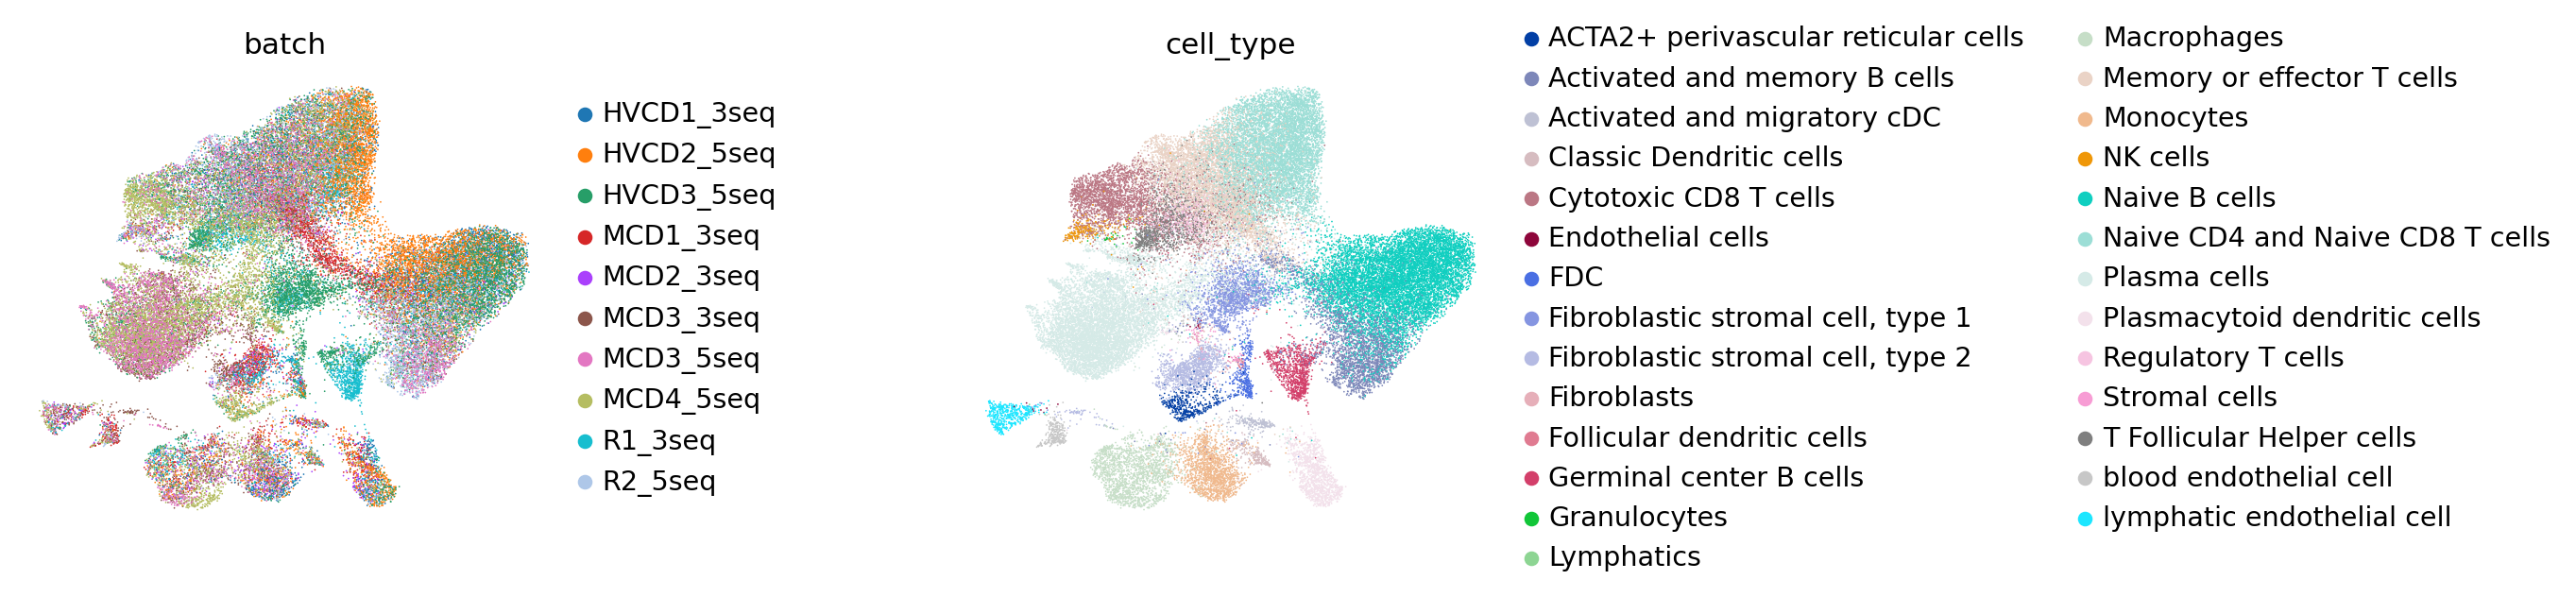

In [34]:
sc.pp.neighbors(reference_latent, n_neighbors=8)
# sc.tl.leiden(reference_latent)
sc.tl.umap(reference_latent)
sc.pl.umap(reference_latent,
           color=['batch', 'cell_type'],
           frameon=False,
           wspace=0.6,
           )

In [35]:
reference_latent.write_h5ad("SCANVI_latent_reference.h5ad")

In [37]:
ref_path = 'ref_model/SCANVI/'
scanvae.save(ref_path, overwrite=True)

## Training on query

In [4]:
# if using GPU
# from pytorch_lightning.trainer.trainer import Trainer
# Trainer(devices = 2)
torch.set_float32_matmul_precision('medium')


In [5]:
ref_path = 'ref_model/SCANVI/'
target_adata = sc.read_h5ad("xenium_dat_scarches.h5ad")

In [6]:
target_adata.obs['edit.ident'] = 'xenium'

In [7]:
model = sca.models.SCANVI.load_query_data(
    target_adata,
    ref_path,
    freeze_dropout = True,
)
model._unlabeled_indices = np.arange(target_adata.n_obs)
model._labeled_indices = []

INFO     File ref_model/SCANVI/model.pt already downloaded                                                         


In [9]:
target_adata

AnnData object with n_obs × n_vars = 2503662 × 403
    obs: 'batch', 'Core', 'Size', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_150_genes', 'n_counts', 'leiden', 'leiden_res2', 'manual_celltype_annotation_leiden_broad', 'manual_celltype_annotation_leiden_broad_split_stromal', 'leiden_res5', 'final_annotation_leiden_res2_broad', 'final_annotation_leiden_res2_fine', 'X_centroid', 'Y_centroid', 'neigh_kmeans', 'neigh_kmeans_fine', 'edit.ident', '_scvi_batch', 'pred_anno_3', '_scvi_labels'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: '_scvi_ma

In [16]:
model.train(
    max_epochs=100,
    plan_kwargs=dict(weight_decay=0.0),
    check_val_every_n_epoch=5,
    # devices=2 # if using 2 GPUs
)

INFO     Training for 100 epochs.                                                                                  


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 100/100: 100%|██████████| 100/100 [6:44:34<00:00, 244.90s/it, v_num=1, train_loss_step=64.8, train_loss_epoch=67.3]

INFO: `Trainer.fit` stopped: `max_epochs=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [6:44:34<00:00, 242.74s/it, v_num=1, train_loss_step=64.8, train_loss_epoch=67.3]


In [17]:
query_latent = sc.AnnData(model.get_latent_representation())
query_latent.obs['cell_type'] = target_adata.obs['final_annotation_leiden_res2_fine'].tolist()

In [18]:
query_latent.obs['predictions'] = model.predict()

Text(0, 0.5, 'Observed')

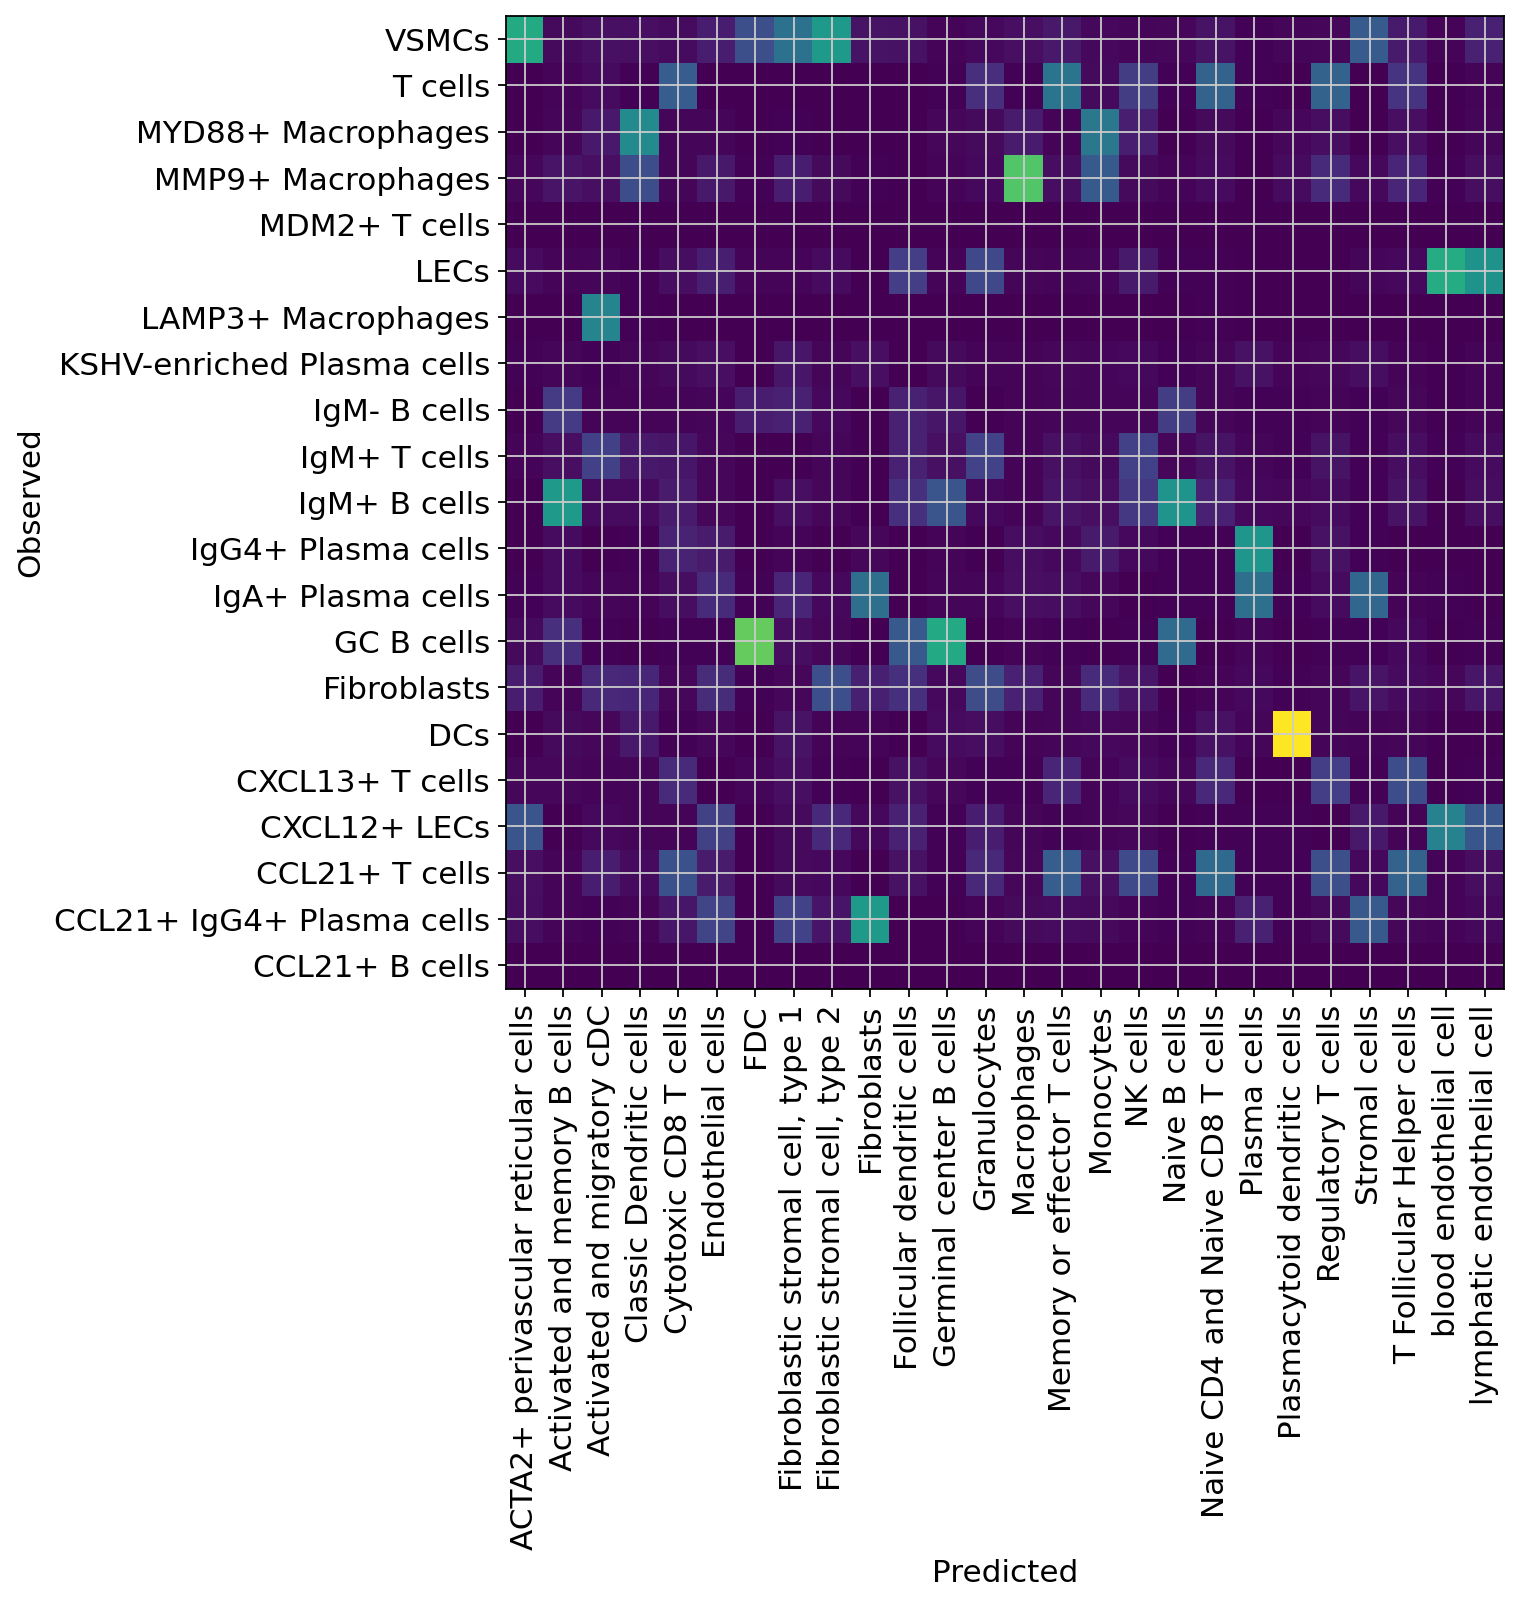

In [19]:
df = query_latent.obs.groupby(["cell_type", "predictions"]).size().unstack(fill_value=0)
norm_df = df / df.sum(axis=0)

plt.figure(figsize=(8, 8))
_ = plt.pcolor(norm_df)
_ = plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns, rotation=90)
_ = plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xlabel("Predicted")
plt.ylabel("Observed")

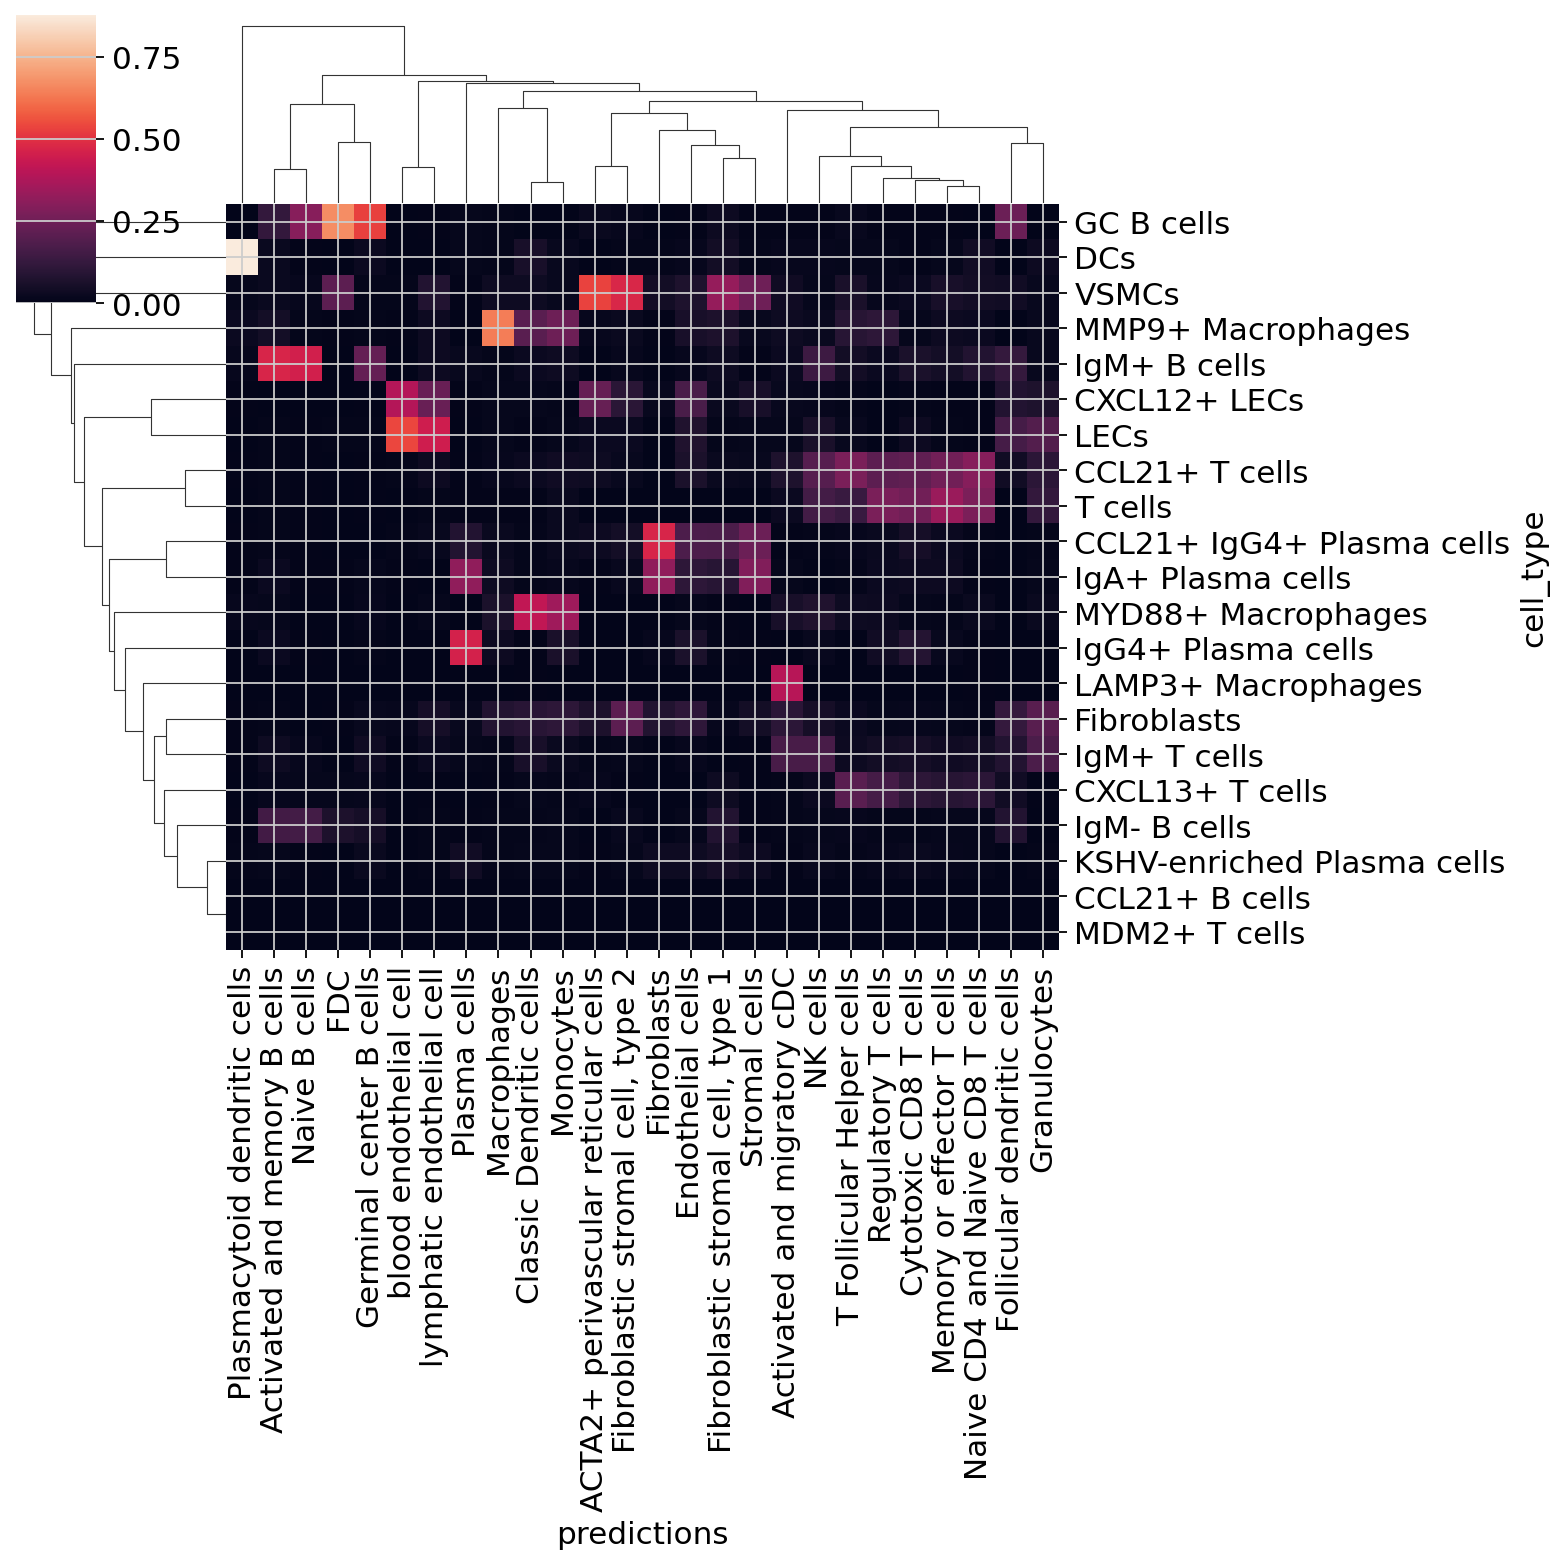

In [25]:
sns.clustermap(norm_df)
plt.savefig("outs/heatmap_scarches_xenium_predictions.png", bbox_inches="tight")

In [20]:
query_latent.write_h5ad("xenium_latent_withPred.h5ad")